In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from paths import mkl_data
#import requests # API library

import random
import time
import os

#from isoweek import Week

#import requests # API library

import numpy as np
import pandas as pd
import json
import re

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive



/tmp/ipykernel_1320/1863951219.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/sandoar/miniconda3/envs/model/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Expects an observation from df
def model2(obs):
    hyper_sigma = 1/8 # consider if this variable is maintained constant during inference.
    # do we want it to be constant?
    
    coach1_mu_skill = 0
    coach1_sigma_skill = 1
    coach1_skill = pyro.sample("coach1_skill", dist.Normal(coach1_mu_skill, coach1_sigma_skill))
    coach2_mu_skill = 0
    coach2_sigma_skill = 1
    coach2_skill = pyro.sample("coach2_skill", dist.Normal(coach2_mu_skill, coach2_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):   

        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skill, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skill, hyper_sigma))

        perf_diff = coach1_perf - coach2_perf
    
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

# Training on fake data where coach 1 always wins.

In [3]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100
#This is fake data, just show that the model can be trained
obs = torch.ones(num_games)
for step in range(num_steps):    
    #Feed in batches (e.g. batches of observations)
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 3221.7855313420296
Step 100 : loss = -10.575533151626587
Step 200 : loss = -35.358983516693115
Step 300 : loss = -26.3419429063797
Step 400 : loss = -34.538692235946655
Step 500 : loss = -27.32930815219879
Step 600 : loss = -34.93195629119873
Step 700 : loss = -34.88365375995636
Step 800 : loss = -39.162896394729614
Step 900 : loss = -27.85892343521118
Step 1000 : loss = -35.75062894821167
Step 1100 : loss = -41.03456366062164
Step 1200 : loss = -28.910413146018982
Step 1300 : loss = -10.081173539161682
Step 1400 : loss = -35.113494873046875
Step 1500 : loss = -26.647016406059265
Step 1600 : loss = -33.11528563499451
Step 1700 : loss = -22.032880663871765
Step 1800 : loss = -34.2509925365448
Step 1900 : loss = -25.233043313026428
Step 2000 : loss = -37.18994963169098
Step 2100 : loss = -23.360941767692566
Step 2200 : loss = -28.148219108581543
Step 2300 : loss = -22.267611384391785
Step 2400 : loss = -35.25900685787201
Step 2500 : loss = -24.736685633659363
Step 2600 : 

In [4]:
from pyro.infer import Predictive

#This is an example of inference after training
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)


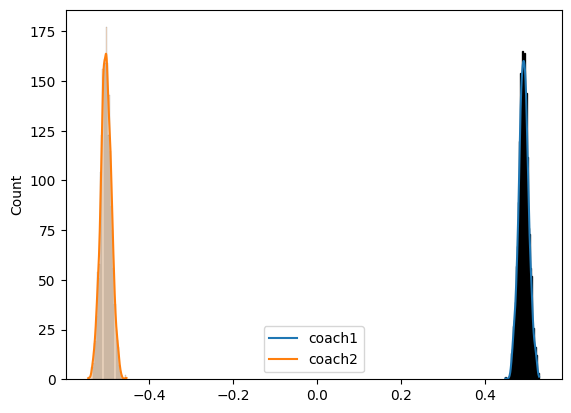

In [5]:
import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Training on fake data where each match is a draw.

In [6]:
# clear param store
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100
#This is fake data, just show that the model can be trained
obs = torch.zeros(num_games)
for step in range(num_steps):    
    #Feed in batches (e.g. batches of observations)
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = -16.50978273153305
Step 100 : loss = 11.073230922222137
Step 200 : loss = -32.3167325258255
Step 300 : loss = -19.67956018447876
Step 400 : loss = -29.957944333553314
Step 500 : loss = -15.092052400112152
Step 600 : loss = -29.72341352701187
Step 700 : loss = -44.88877213001251
Step 800 : loss = -39.36153417825699
Step 900 : loss = -32.04777252674103
Step 1000 : loss = -31.51994502544403
Step 1100 : loss = -39.14912003278732
Step 1200 : loss = -27.221411168575287
Step 1300 : loss = -20.492088556289673
Step 1400 : loss = -29.831747889518738
Step 1500 : loss = -41.09873849153519
Step 1600 : loss = -30.58950936794281
Step 1700 : loss = -19.577418327331543
Step 1800 : loss = -34.181437373161316
Step 1900 : loss = -35.406321346759796
Step 2000 : loss = -30.466621935367584
Step 2100 : loss = -35.70874774456024
Step 2200 : loss = -29.43023318052292
Step 2300 : loss = -33.25841301679611
Step 2400 : loss = -32.578144788742065
Step 2500 : loss = -25.897383153438568
Step 2600 : lo

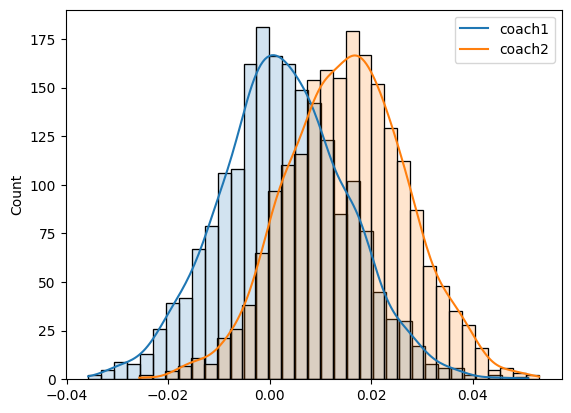

In [7]:
from pyro.infer import Predictive

#This is an example of inference after training
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Training on fake data where coach 2 always wins.

In [8]:
# clear param store
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100
#This is fake data, just show that the model can be trained
obs = -torch.ones(num_games)
for step in range(num_steps):    
    #Feed in batches (e.g. batches of observations)
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 3351.2997601628304
Step 100 : loss = -32.97707653045654
Step 200 : loss = -4.528622150421143
Step 300 : loss = -42.661919713020325
Step 400 : loss = -47.37082505226135
Step 500 : loss = -28.38119399547577
Step 600 : loss = -34.63734447956085
Step 700 : loss = -30.000990748405457
Step 800 : loss = -18.151569604873657
Step 900 : loss = -23.218701004981995
Step 1000 : loss = -39.12788641452789
Step 1100 : loss = -36.88239884376526
Step 1200 : loss = -32.81950879096985
Step 1300 : loss = -27.220876097679138
Step 1400 : loss = -19.977776885032654
Step 1500 : loss = -29.855722665786743
Step 1600 : loss = -31.381070017814636
Step 1700 : loss = -28.803999185562134
Step 1800 : loss = -39.94666874408722
Step 1900 : loss = -28.8308984041214
Step 2000 : loss = -28.305358290672302
Step 2100 : loss = -30.343210458755493
Step 2200 : loss = -35.7847044467926
Step 2300 : loss = -28.270097732543945
Step 2400 : loss = -30.807883739471436
Step 2500 : loss = -27.470141768455505
Step 2600 : 

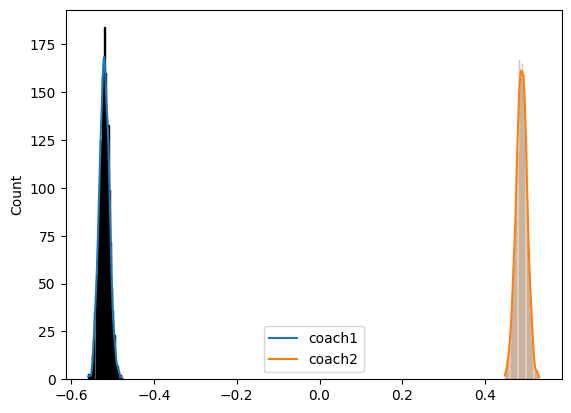

In [9]:
from pyro.infer import Predictive

#This is an example of inference after training
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Comparing distributions from fake data based on number of games played.

In [17]:
from pyro.infer import Predictive

# clear param store
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})

coach1_skill_inf = np.empty((3, 2000))
coach2_skill_inf = np.empty((3, 2000))

for i in range(1,4):
    pyro.clear_param_store()

    # Training loop
    num_steps = 5000
    num_games = 10**i

    guide = AutoNormal(model2)
    svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

    print(f"Training for {num_games} games")
    #This is fake data, just show that the model can be trained
    obs = torch.ones(num_games)
    for step in range(num_steps):    
        #Feed in batches (e.g. batches of observations)
        loss = svi.step(obs)
        """if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")"""


    #This is an example of inference after training
    predictive = Predictive(model2, guide=guide, num_samples=2000,
                            return_sites=("coach1_skill", "coach2_skill"))

    samples = predictive(obs)

    coach1_skill_inf[i-2] = samples["coach1_skill"].detach().squeeze()
    coach2_skill_inf[i-2] = samples["coach2_skill"].detach().squeeze()



Training for 10 games
Training for 100 games
Training for 1000 games


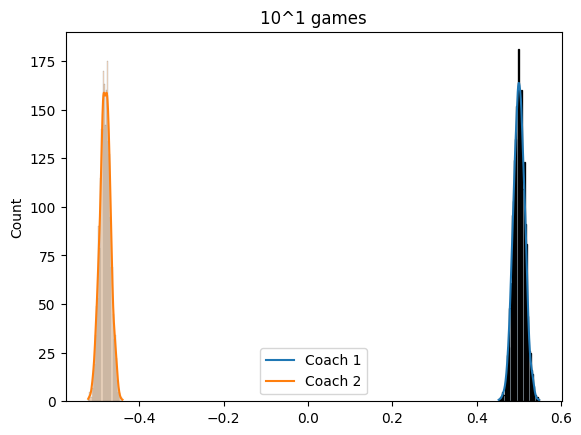

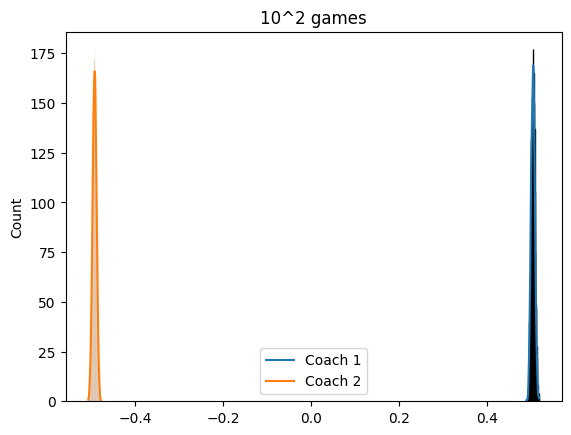

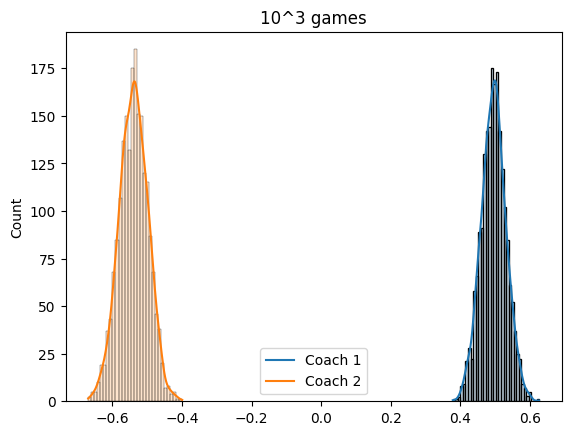

In [19]:
import seaborn as sns


#Plotting the data
sns.histplot(coach1_skill_inf[0], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[0], kde=True, alpha=0.2)
plt.title("10^1 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

sns.histplot(coach1_skill_inf[1], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[1], kde=True, alpha=0.2)
plt.title("10^2 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

sns.histplot(coach1_skill_inf[2], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[2], kde=True, alpha=0.2)
plt.title("10^3 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

# Lets try and make some fake data where coach 1 starts by losing but slowly gets better.

In [12]:
obs1 = -torch.ones(100)
obs2 = torch.zeros(100)
obs3 = torch.ones(200)

obs = torch.cat((obs1, obs2, obs3))

# clear param store
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
#This is fake data, just show that the model can be trained
for step in range(num_steps):    
    #Feed in batches (e.g. batches of observations)
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 9602.321646153927
Step 100 : loss = 2892.8823498487473
Step 200 : loss = 2800.1529259085655
Step 300 : loss = 2781.5691507458687
Step 400 : loss = 2794.4159086942673
Step 500 : loss = 2776.9377309679985
Step 600 : loss = 2796.0466737151146
Step 700 : loss = 2771.004020154476
Step 800 : loss = 2752.8027907013893
Step 900 : loss = 2766.6397944688797
Step 1000 : loss = 2783.3776005506516
Step 1100 : loss = 2782.235462963581
Step 1200 : loss = 2771.3849016427994
Step 1300 : loss = 2803.441429078579
Step 1400 : loss = 2788.4784403443336
Step 1500 : loss = 2796.329504132271
Step 1600 : loss = 2773.7751830220222
Step 1700 : loss = 2781.288900732994
Step 1800 : loss = 2769.727006971836
Step 1900 : loss = 2779.2601764798164
Step 2000 : loss = 2764.6909943819046
Step 2100 : loss = 2790.3894286751747
Step 2200 : loss = 2778.953609764576
Step 2300 : loss = 2776.07114982605
Step 2400 : loss = 2792.4117200374603
Step 2500 : loss = 2789.022524178028
Step 2600 : loss = 2779.70325034856

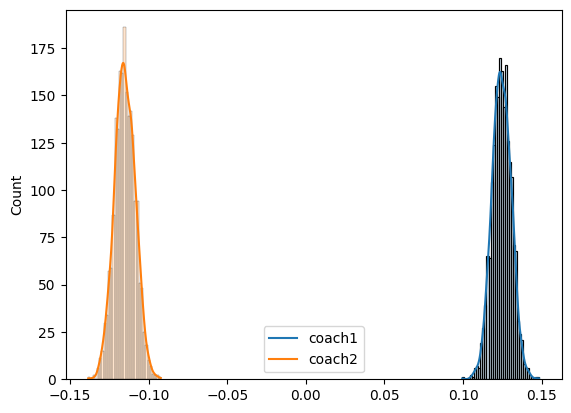

In [13]:
from pyro.infer import Predictive

#This is an example of inference after training
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()